In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import scipy
from PIL import Image
from scipy import ndimage
import gdal
import os
import geopandas as gpd
from skimage import io
from skimage.io import imread
%matplotlib inline

### reading the image with predicted labels of each pixel

In [2]:
path = "E:\\Internship_Harvesting\\Unsupervised_Result_Image\\predicted_map_with_georeferencing.tif"

In [3]:
actual = gdal.Open(path)
actual

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002330C32CAB0> >

In [4]:
actual.RasterYSize, actual.RasterXSize, actual.RasterCount

(8963, 8298, 4)

### storing each band in a separate numpy array

In [5]:
actual_band1 = actual.GetRasterBand(1).ReadAsArray()
actual_band2 = actual.GetRasterBand(2).ReadAsArray()
actual_band3 = actual.GetRasterBand(3).ReadAsArray()
actual_band4 = actual.GetRasterBand(4).ReadAsArray()

In [6]:
np.unique(actual_band1)

array([  0, 255], dtype=uint8)

In [7]:
np.unique(actual_band2)

array([  0, 255], dtype=uint8)

In [8]:
np.unique(actual_band3)

array([  0, 255], dtype=uint8)

In [9]:
np.unique(actual_band4)

array([  0, 255], dtype=uint8)

### visualization of the 4 bands

In [10]:
actual_band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

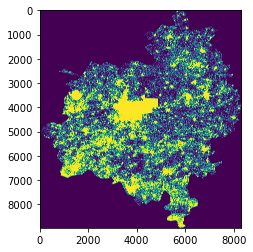

In [11]:
plt.imshow(actual_band1)
plt.show()

In [12]:
actual_band2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

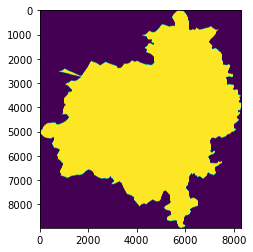

In [13]:
plt.imshow(actual_band2)
plt.show()

In [14]:
actual_band3

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

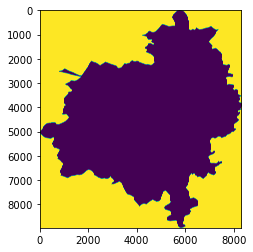

In [15]:
plt.imshow(actual_band3)
plt.show()

In [16]:
np.count_nonzero(actual_band3 == 255)

35318365

In [17]:
actual_band4

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

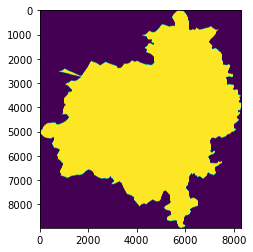

In [18]:
plt.imshow(actual_band4)
plt.show()

In [19]:
np.count_nonzero(actual_band4 == 0)

35318365

### it seems that only band1 is useful for us
### comparing our results with this.

### Now as band1 of the image consists of only 2 values 0 and 255 and also the non-agriculture part is not mapped we need to map it and then compare the agriculture part

### reading the input file 10_2019for extracting the indices of nan(outside bathinda)

In [20]:
I1B1 = gdal.Open("E:\\Internship_Harvesting\\Dataset\\10_2019.tif")
I1B1

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002330C32CA50> >

In [21]:
I1B1_array = I1B1.GetRasterBand(1).ReadAsArray()

In [22]:
I1B1_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [23]:
np.count_nonzero(np.isnan(I1B1_array))

35318365

In [24]:
nan_index = np.argwhere(np.isnan(I1B1_array))

In [25]:
nan_index.shape

(35318365, 2)

### changing the values of all the nan indices to 128 from 0

In [26]:
for i in range(nan_index.shape[0]):
    actual_band1[nan_index[i,0], nan_index[i,1]] = 128

### after setting the nan indices to 128, the image (band1) looks this below

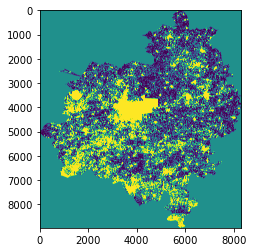

In [28]:
plt.imshow(actual_band1)
plt.show()

In [29]:
actual_band1

array([[128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ...,
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128]], dtype=uint8)

# for actual band1 image
### counting the number of nan(128) indices
### counting the number of wheat(0) indices
### counting the number of non-agri(inside bathinda) + agri(non-wheat)(255) indices

In [31]:
np.count_nonzero(actual_band1 == 0), np.count_nonzero(actual_band1 == 255), np.count_nonzero(actual_band1 == 128)

(21623230, 17433379, 35318365)

### reading the predicted image using unsupervised K-means Classification, NDVI feature reduction approach

In [32]:
predict = gdal.Open("E:\\Internship_Harvesting\\Unsupervised_Result_Image\\NDVI_red_kmeans_result.tif")
predict

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000233488007E0> >

In [33]:
predict_array = predict.GetRasterBand(1).ReadAsArray()

In [34]:
np.unique(predict_array)

array([  0, 128, 255], dtype=uint8)

### visualizing the predicted image

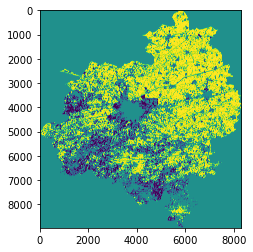

In [35]:
plt.imshow(predict_array)
plt.show()

# for predicted image
### counting the number of nan(outside bathinda + non-agri inside bathinda)(128) indices
### counting the number of wheat(255) indices
### counting the number of agri(non-wheat)(0) indices

In [36]:
np.count_nonzero(predict_array == 0), np.count_nonzero(predict_array == 255), np.count_nonzero(predict_array == 128)

(10593280, 23206785, 40574909)

### extracting nan indices from the predicted image

In [43]:
nan_index_predict = np.argwhere(predict_array == 128)

In [44]:
nan_index_predict.shape

(40574909, 2)

### setting all nan indices extracted from predicted image to 128 in the actual band1

In [46]:
for i in range(nan_index_predict.shape[0]):
    actual_band1[nan_index_predict[i,0], nan_index_predict[i,1]] = 128

# for actual band1
### counting the number of nan(outside bathinda + non-agri inside bathinda)(128) indices
### counting the number of wheat(0) indices
### counting the number of agri(non-wheat)(255) indices

In [47]:
np.count_nonzero(actual_band1 == 0), np.count_nonzero(actual_band1 == 255), np.count_nonzero(actual_band1 == 128)

(20841637, 12958428, 40574909)

### setting the wheat pixels to value 255 which is 0 at present
### also setting the non-wheat pixels to value 0 which is 255 at present

In [49]:
actual_band1[actual_band1 == 0] = 100

In [50]:
actual_band1[actual_band1 == 255] = 0

In [51]:
actual_band1[actual_band1 == 100] = 255

# Counting the number of pixels with different values for both actual band1 and predicted image

In [52]:
np.count_nonzero(actual_band1 == 0), np.count_nonzero(actual_band1 == 255), np.count_nonzero(actual_band1 == 128)

(12958428, 20841637, 40574909)

In [55]:
np.count_nonzero(predict_array == 0), np.count_nonzero(predict_array == 255), np.count_nonzero(predict_array == 128)

(10593280, 23206785, 40574909)

### from above 2 code chunks we have
# for actual band1
#### number of pixels with non-wheat(agriculture) label = 12958428
#### number of pixels with wheat(agriculture) label = 20841637
#### number of pixels with (non-agriculture + outside bathinda) labeled as 128 = 40574909

# for predicted image
#### number of pixels with non-wheat(agriculture) label = 10593280
#### number of pixels with wheat(agriculture) label = 23206785
#### number of pixels with (non-agriculture + outside bathinda) labeled as 128 = 40574909

# Visulizing the both actual band1 and predicted images

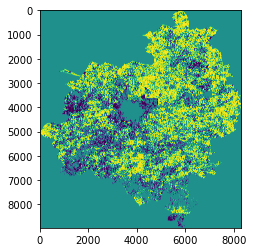

In [53]:
plt.imshow(actual_band1)
plt.show()

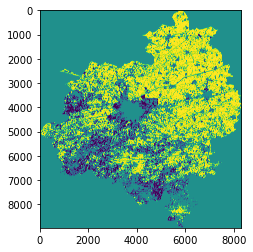

In [54]:
plt.imshow(predict_array)
plt.show()

# Forming Confusion Matrix
### extracting the indices having label as wheat(255) from actual band1

In [56]:
wheat_index_actual = np.argwhere(actual_band1 == 255)

In [57]:
wheat_index_actual.shape

(20841637, 2)

In [58]:
wheat_index_actual

array([[   0, 5739],
       [   0, 5740],
       [   0, 5741],
       ...,
       [8942, 5812],
       [8942, 5816],
       [8942, 5817]], dtype=int64)

### comparing the values of predicted and actual band1 for wheat_index_actual indices
### if they match we have truely predicted wheat
### else we have falsely predicted non-wheat

In [60]:
true_wheat = 0
false_non_wheat = 0

In [61]:
for i in range(wheat_index_actual.shape[0]):
    if predict_array[wheat_index_actual[i,0], wheat_index_actual[i,1]] == 255:
        true_wheat = true_wheat + 1
    else:
        false_non_wheat = false_non_wheat + 1

In [62]:
true_wheat, false_non_wheat

(18992243, 1849394)

### so we have,
### number of pixels which are wheat and their prediction is true = 18992243
### number of pixels which are wheat but are falsely predicted non-wheat = 1849394

## doing similar process for non-wheat pixels,
### extracting the indices having label as non-wheat(0) from actual band1

In [64]:
non_wheat_index_actual = np.argwhere(actual_band1 == 0)

In [65]:
non_wheat_index_actual.shape

(12958428, 2)

In [66]:
non_wheat_index_actual

array([[   0, 5738],
       [   3, 5703],
       [   3, 5715],
       ...,
       [8962, 5788],
       [8962, 5789],
       [8962, 5790]], dtype=int64)

### comparing the values of predicted and actual band1 for non_wheat_index_actual indices
### if they match we have truely predicted non-wheat
### else we have falsely predicted wheat

In [63]:
false_wheat = 0
true_non_wheat = 0

In [67]:
for i in range(non_wheat_index_actual.shape[0]):
    if predict_array[non_wheat_index_actual[i,0], non_wheat_index_actual[i,1]] == 0:
        true_non_wheat = true_non_wheat + 1
    else:
        false_wheat = false_wheat + 1

In [68]:
true_non_wheat, false_wheat

(8743886, 4214542)

### so we have,
### number of pixels which are non-wheat and their prediction is true = 8743886
### number of pixels which are non-wheat but are falsely predicted as wheat = 4214542

### once we have all the 4 values for calculating precision, recall, accuracy, also F1 score we will do that

# PRECISION = 0.8184

In [69]:
precision = true_wheat / (true_wheat + false_wheat)
precision

0.8183918194614205

# RECALL = 0.9113

In [70]:
recall = true_wheat / (true_wheat + false_non_wheat)
recall

0.9112644558582419

# F1 SCORE = 0.8623

In [11]:
f1_score = 2 / ((1 / precision) + (1 / recall))
f1_score

0.8623347733092459

# ACCURACY = 0.8206

In [72]:
accuracy = (true_wheat + true_non_wheat) / (true_wheat + false_non_wheat + true_non_wheat + false_wheat)
accuracy

0.8205939544790817